This Notebook needs https://github.com/mineo/mpd_pydb for reading MPDs database

In [1]:
%pylab inline
matplotlib.style.use("ggplot")
import mpd_pydb as mpd
from os.path import expanduser
db = mpd.Database.read_file(expanduser("~/.mpd/mpd.db"))
df = db.to_dataframe()

Populating the interactive namespace from numpy and matplotlib


In [2]:
df[["Album", "Artist", "AlbumArtist", "Title", "Date"]].describe()

,Album,Artist,AlbumArtist,Title,Date
count,18026,18081,17901,18081,17310
unique,1495,3790,705,16695,997
top,A Traveler’s Guide to Space and Time,John Williams,Various Artists,Intro,2003
freq,168,311,2837,16,237


# Song length distribution

In [3]:
times = df["Time"]
times.describe()

count    18087.000000
mean       216.902531
std        121.816014
min          0.026000
25%        142.628000
50%        209.763000
75%        267.788500
max       3445.440000
Name: Time, dtype: float64

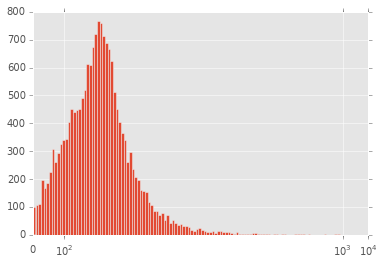

In [ ]:
fig, ax = plt.subplots()
times.hist(ax=ax, bins=400)
ax.set_xscale("symlog", linthreshx=1000, linscalex=11)

Ok, there seem be some very long songs in the DB, let's ignore them for now. We're going to limit the song length to 600 seconds (10 minutes).

In [ ]:
t = times[times <= 600]
fig, ax = plt.subplots()
t.hist(ax=ax, bins=600)
ax.set_ylim(top=125)

(0.0, 125)

But let's also have a look at the songs longer than 600 seconds:

In [ ]:
t = times[times > 600]
fig, ax = plt.subplots()
t.hist(ax=ax, bins=80)

# Duplicate tracks by recording id

In [ ]:
trs = df[["MUSICBRAINZ_TRACKID", "Artist", "Title"]]
trs[trs.duplicated(subset=["MUSICBRAINZ_TRACKID"]) == True]

# Release dates

In [ ]:
def date_to_year(series):
    def conv(date):
        if date is None:
            return date
        return int(date.split("-")[0])
    return series.apply(conv)
date_data = df[["Date", "Album"]]
date_data = date_data.assign(Date=date_to_year(date_data["Date"]))

In [ ]:
def plot_date_data(dates):
    d = dates["Date"]
    min_date = d.min()
    max_date = d.max()
    d.hist(range=(min_date, max_date),
                  bins=max_date-min_date)

## Release date histogram with dates from tracks

Dates of albums with more tracks will have more impact on this plot

In [ ]:
date_data.describe()

In [ ]:
plot_date_data(date_data)

## Release date histogram with dates from albums

First, select the distinct Album-Date data and then plot it.

In [ ]:
new_date_data = date_data.drop_duplicates()
new_date_data.describe()

In [ ]:
plot_date_data(new_date_data)

# Amount of albums with unknown dates

In [ ]:
unknown_dates = new_date_data.assign(DateKnown=~np.isnan(new_date_data["Date"]))\
    [["DateKnown", "Album"]].\
    groupby(["DateKnown"]).\
    count()
unknown_dates

In [ ]:
unknown_dates.plot(kind="pie", subplots=True, figsize=(7,7))

# Artist-Album relationships

In [ ]:
df[["Artist", "Album"]].drop_duplicates().\
    groupby("Album").count().sort(["Artist"], ascending=False)

In [ ]:
art_alb_data = df[["AlbumArtist", "Album"]].drop_duplicates().\
    groupby("AlbumArtist").count()

In [ ]:
art_alb_data.sort(["Album"], ascending=False)